In [115]:
import h5py
import deepdish as dd
from convergenets.utils import utils
from scripts.visualizations.helpers import load_weights
from tqdm import tqdm
from tqdm import trange

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import itertools
import deepdish as dd
from scipy.stats import norm as sp_norm
from sklearn.linear_model import LinearRegression


In [2]:
flags = ["overwrite"]
CACHE_PATH = "/mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics"

def create_args_string(kwargs, flags, pre_command="python train.py", subset_keys=None):
    s = f"{pre_command} "
    if subset_keys is not None:
        kwargs = {k:v for k,v in kwargs.items() if k in subset_keys}
    for k, v in kwargs.items():
        s += f"--{k} {v} "
    for f in flags:
        s += f"--{f} "
    return s

In [5]:
def load_cache(experiment="hessian", expid="imagenet_pret_ce", expid_eigenvalues=None, **kwargs):
    if expid_eigenvalues is None:
        expid_eigenvalues = expid
    PT_CACHE_DIR = "/mnt/fs6/jvrsgsty/neural-mechanics"
    traj_cache = f"{PT_CACHE_DIR}/{experiment}/{expid}/cache/pos_vel.h5"
    weights = dd.io.load(traj_cache, f"/metrics/position")
    grads = dd.io.load(traj_cache, f"/metrics/velocity")
    spectral_cache = f"{PT_CACHE_DIR}/{experiment}/{expid_eigenvalues}/metrics/spectral.h5"
    eigenvectors = dd.io.load(spectral_cache, f"/eigenvector")
    eigenvalues = dd.io.load(spectral_cache, f"/eigenvalues")
    eigen_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[eigen_idx]
    eigenvectors = eigenvectors[:,eigen_idx]
    assert weights.shape == grads.shape
    assert weights.shape[1] == eigenvectors.shape[0]
    return weights, grads, eigenvectors, eigenvalues
    
def project(weights, grads, eigenvectors,eig_idx = 0): 
    projected_weights = np.array(
        [np.dot(weights[i], eigenvectors[:, eig_idx]) for i in range(weights.shape[0])]
    )
    projected_grads = np.array(
        [np.dot(grads[i], eigenvectors[:, eig_idx]) for i in range(grads.shape[0])]
    )
    return projected_weights, projected_grads


In [49]:
def compute_fft(time_series, sample_spacing):
    ft = np.fft.rfft(time_series, axis=0)
    frequency = np.fft.rfftfreq(len(time_series), sample_spacing)

    fft = {
        "amplitude": np.abs(ft),
        "phase": np.angle(ft),
        "ft": ft,
        "frequency": frequency, # returned in cycles/sample_spacing
    }
    fft["w_avg_freq"] = np.average(fft["frequency"][1:], weights=fft["amplitude"][1:])
    return fft

def plot_fft(ax, fft, label=""):
    ax.errorbar(
        fft["frequency"][1:],
        fft["amplitude"][1:],
        label=label,
    )
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Frequency (Hz)")

In [434]:
experiment = "pretrained_imagenet"
momentum=0.999
lr = 0.1
expid = f"rest18_mom{str(momentum).split('.')[1]}"
eig_idx = 0
projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
    experiment, expid, subdir="/jv_neural_mechanics", suffix="_10eig_10it_40k")
projected_weights = projected_weights[3:]
projected_grads = projected_grads[3:]



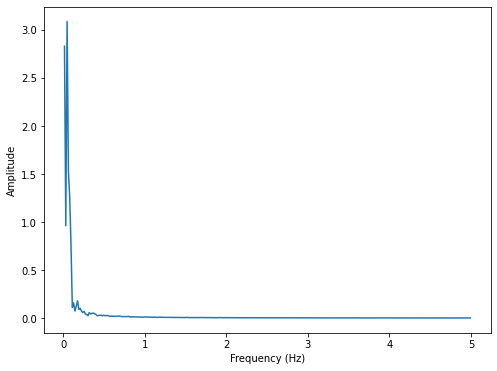

In [435]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows))

a = compute_fft(projected_weights[:, eig_idx], lr)
plot_fft(axes, a)

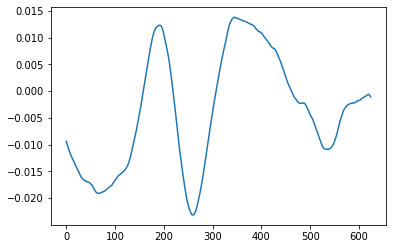

In [437]:
plt.plot(projected_weights[:, eig_idx])

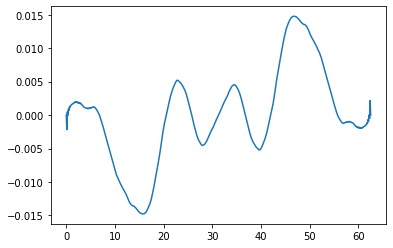

In [500]:
y = 0
x =lr* np.linspace(0,projected_weights.shape[0],600)
j = complex(0,1)
for i in range(len(a["frequency"])):
    y += np.sin(a["frequency"][i] * 2 * np.pi * x) * a["ft"][i].real + j*np.cos(a["frequency"][i] * 2 * np.pi * x) * a["ft"][i].imag
    #y += a["ft"][i] * np.exp(j*2*np.pi* a["frequency"][i] * x / a["frequency"].shape[0])
y /= a["frequency"].shape[0]
plt.plot(x,y)

## Linear regression

In [64]:
experiment = "linear_regression"
momentum= 0.99
lr = 1e-4
wd = 1e-4
bs = 1024

lr_= f"{lr:1.0e}".replace("-","n")
wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
mom_ = f"{momentum}".replace(".", "")
expid = f"cifar10_hessian_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
eig_idx = 0

weights, grads, eigenvectors, eigenvalues = load_cache(experiment, 
                                                       expid,
                                                       "cifar10_hessian_evals_many_100")
avg_freq_pos = []
avg_freq_vel = []
avg_freq_pos_t = []
avg_freq_vel_t = []
for eig_idx in range(96):
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    timet_start = 0
    _, (time, theory_pos, theory_vel) = traj_mse(projected_weights, 
                                                 projected_grads, 
                                                 timet_start, 
                                                 lr, 
                                                 momentum, 
                                                 wd, 
                                                 eigenvalues, 
                                                 eig_idx=eig_idx)

    
    avg_freq_pos.append(compute_fft(projected_weights, lr)["w_avg_freq"])
    avg_freq_vel.append(compute_fft(projected_grads, lr)["w_avg_freq"])
    avg_freq_pos_t.append(compute_fft(theory_pos, lr)["w_avg_freq"])
    avg_freq_vel_t.append(compute_fft(theory_vel, lr)["w_avg_freq"])

avg_freq_pos = np.array(avg_freq_pos)  
avg_freq_vel = np.array(avg_freq_vel)  
avg_freq_pos_t = np.array(avg_freq_pos_t)  
avg_freq_vel_t = np.array(avg_freq_vel_t)  

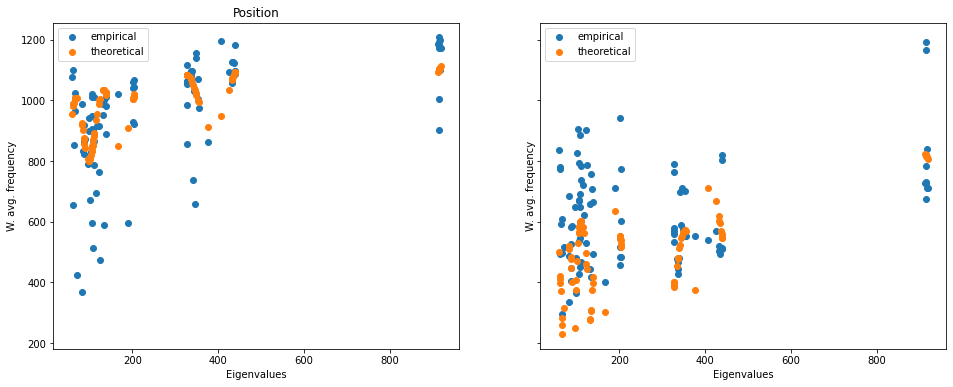

In [65]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows), sharey=True)

axes[0].scatter(eigenvalues[:96], avg_freq_pos, label="empirical")
axes[0].set_xlabel("Eigenvalues")
axes[0].set_ylabel("W. avg. frequency")
axes[0].set_title("Position")

axes[1].scatter(eigenvalues[:96], avg_freq_vel, label="empirical")
axes[1].set_xlabel("Eigenvalues")
axes[1].set_ylabel("W. avg. frequency")
#axes[1].set_title("Empirical Velocity")

axes[0].scatter(eigenvalues[:96], avg_freq_pos_t, label="theoretical")
axes[0].set_xlabel("Eigenvalues")
axes[0].set_ylabel("W. avg. frequency")
axes[0].set_title("Position")
axes[0].legend()

axes[1].scatter(eigenvalues[:96], avg_freq_vel_t, label="theoretical")
axes[1].set_xlabel("Eigenvalues")
axes[1].set_ylabel("W. avg. frequency")
#axes[1].set_title("Theoretical Velocity")
axes[1].legend()

In [66]:
eigenvalues

array([ 919.6143  ,  917.6894  ,  917.3457  ,  916.22406 ,  916.16833 ,
        915.9801  ,  915.8463  ,  915.5576  ,  915.25085 ,  913.9406  ,
        439.62076 ,  439.56375 ,  439.4851  ,  438.30658 ,  437.04135 ,
        434.27905 ,  433.3842  ,  431.5703  ,  424.3527  ,  407.6842  ,
        376.2946  ,  354.32687 ,  354.06488 ,  352.86792 ,  349.45602 ,
        348.3996  ,  346.0845  ,  344.73767 ,  341.51654 ,  340.14957 ,
        336.26096 ,  336.19186 ,  335.89932 ,  333.7145  ,  328.2923  ,
        328.27728 ,  328.21918 ,  327.65875 ,  327.39267 ,  326.38306 ,
        204.60793 ,  203.73546 ,  202.86    ,  202.64072 ,  202.33565 ,
        201.84319 ,  201.70494 ,  189.03412 ,  165.87735 ,  139.52509 ,
        138.4719  ,  137.3025  ,  134.20215 ,  133.94228 ,  132.43477 ,
        131.87425 ,  123.58434 ,  122.889305,  121.06418 ,  116.89345 ,
        114.86768 ,  110.81606 ,  110.58513 ,  110.05644 ,  108.8292  ,
        108.788956,  108.74754 ,  107.18384 ,  107.14004 ,  106.

## Logistic regression

In [56]:
experiment = "linear_regression"
momentum= 0.99
lr = 1e-4
wd = 1e-4
bs = 1024

lr_= f"{lr:1.0e}".replace("-","n")
wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
mom_ = f"{momentum}".replace(".", "")
expid = f"cifar10_hessian_ce_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
eig_idx = 0

weights, grads, eigenvectors, eigenvalues = load_cache(experiment, 
                                                       expid)
    
projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)

_, (time, theory_pos, theory_vel) = traj_mse(projected_weights, projected_grads, timet_start, lr, momentum, wd, eigenvalues, eig_idx=0)


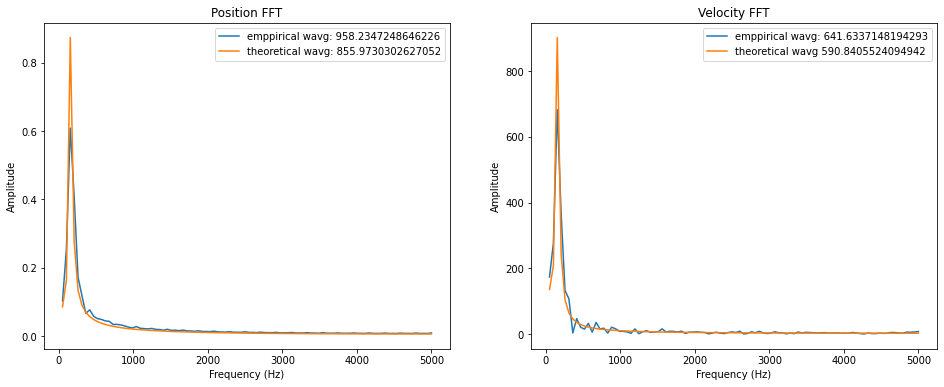

In [57]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows))

e_fft_w = compute_fft(projected_weights, lr)
plot_fft(axes[0], e_fft_w, label=f"emppirical wavg: {e_fft_w['w_avg_freq']}")
axes[0].set_title(f"Position FFT")

t_fft_w = compute_fft(theory_pos, lr)
plot_fft(axes[0], t_fft_w, label=f"theoretical wavg: {t_fft_w['w_avg_freq']}")
axes[0].set_title(f"Position FFT")
axes[0].legend()

e_fft_g = compute_fft(projected_grads, lr)
plot_fft(axes[1], e_fft_g, label=f"emppirical wavg: {e_fft_g['w_avg_freq']}")
axes[1].set_title(f"Velocity FFT")

t_fft_g = compute_fft(-theory_vel, lr)
plot_fft(axes[1], t_fft_g, label=f"theoretical wavg {t_fft_g['w_avg_freq']}")
axes[1].set_title(f"Velocity FFT")
axes[1].legend()

## Cifar10 VGG16

In [69]:
experiment = "nonlinear"
momentum= 0.99
lr = 1e-1
wd = 1e-4
bs = 1024

lr_= f"{lr:1.0e}".replace("-","n")
wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
mom_ = f"{momentum}".replace(".", "")
expid = f"cifar10_vgg11_mse_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
eig_idx = 0
projected_weights, projected_grads, eigenvectors, eigenvalues = load_cache_new(
    experiment, expid)
projected_weights = projected_weights[3:, eig_idx]
projected_grads = projected_grads[3:, eig_idx]
timet_start = 0


_, (time, theory_pos, theory_vel) = traj_mse(projected_weights, projected_grads, timet_start, lr, momentum, wd, eigenvalues, eig_idx=0)


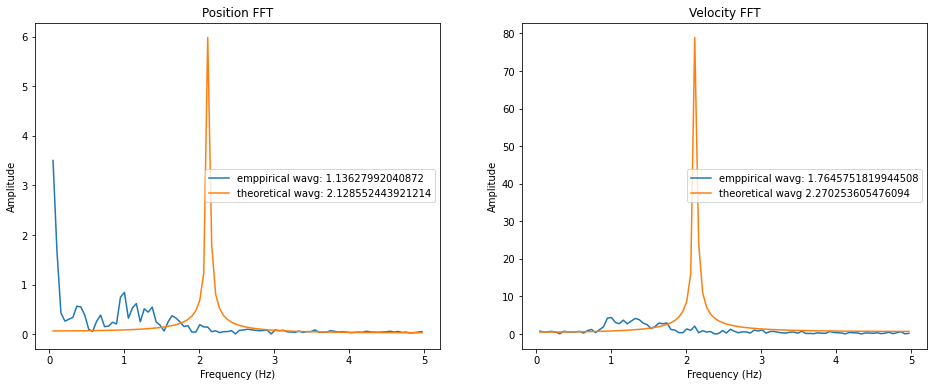

In [62]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows))

e_fft_w = compute_fft(projected_weights, lr)
plot_fft(axes[0], e_fft_w, label=f"emppirical wavg: {e_fft_w['w_avg_freq']}")
axes[0].set_title(f"Position FFT")

t_fft_w = compute_fft(theory_pos, lr)
plot_fft(axes[0], t_fft_w, label=f"theoretical wavg: {t_fft_w['w_avg_freq']}")
axes[0].set_title(f"Position FFT")
axes[0].legend()

e_fft_g = compute_fft(projected_grads, lr)
plot_fft(axes[1], e_fft_g, label=f"emppirical wavg: {e_fft_g['w_avg_freq']}")
axes[1].set_title(f"Velocity FFT")

t_fft_g = compute_fft(-theory_vel, lr)
plot_fft(axes[1], t_fft_g, label=f"theoretical wavg {t_fft_g['w_avg_freq']}")
axes[1].set_title(f"Velocity FFT")
axes[1].legend()